In [34]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import segmentation, color
from skimage.future import graph
from skimage.segmentation import quickshift
import os
import math
from PIL import Image

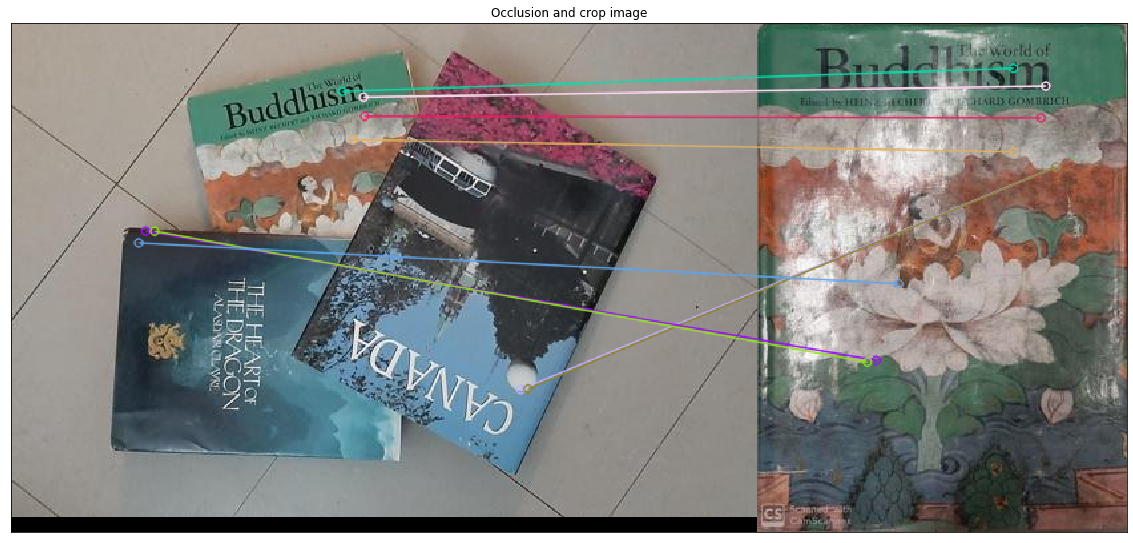

In [35]:
# Find SIFT keypoints in given input images.
# load image 
img = cv2.imread("book_occlusion.jpg")
img_occlusion = cv2.imread("book_occlusion.jpg")
img_crop = cv2.imread("book_crop.jpg")
# copy image
img_occlusion_copy = img_occlusion.copy()
img_crop_copy = img_crop.copy()
# convert to RGB
img_occlusion = cv2.cvtColor(img_occlusion, cv2.COLOR_BGR2RGB)
img_occlusion_copy = cv2.cvtColor(img_occlusion_copy, cv2.COLOR_BGR2RGB)
img_crop = cv2.cvtColor(img_crop, cv2.COLOR_BGR2RGB)
img_crop_copy = cv2.cvtColor(img_crop_copy, cv2.COLOR_BGR2RGB)

# # Create a rotated, scaled duplicate
# # rotation marix around the center pixel, -30 degrees,scale of 1
# # Actually get the pivot, so it not necessary is 1/2
# M_rotated = cv2.getRotationMatrix2D((width/2,height/2),15,0.65)
# # Apply the transformation matrix
# # Why i need the size of the image: if I transform it (rotate it) the object is actually out of the image
# img_crop_copy = cv2.warpAffine(img_crop_copy,M_rotated,(width,height))

# create a SIFT object
sift = cv2.xfeatures2d.SIFT_create() # replace with SURF_create() for SURF features
title = "Occlusion and crop image"
# detect SIFT features, with no masks
# 'None' is a mask but here is no masks so it is none
# Sometime we want to just compute the key points just in the mask
keypoints_occlusion,descriptors_occlusion = sift.detectAndCompute(img_occlusion_copy,None)
keypoints_crop,descriptors_crop = sift.detectAndCompute(img_crop_copy,None)

# create BFMatcher object
# BF == brute force
bf = cv2.BFMatcher()#cv2.NORM_HAMMING, crossCheck=True)\

# Match keypoints of reference image to the keypoints of the occluded image using brute-force method.
# Match descriptors.
# Match the first arguement to the second
matches = bf.match(descriptors_occlusion,descriptors_crop) #query image, train image

# Sort matching keypoints according to the matching distance.
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Display top ten matching keypoints.
# Draw first 10 matches.
img_matches = cv2.drawMatches(img_occlusion_copy,keypoints_occlusion
                              ,img_crop_copy,keypoints_crop, matches[:10], None, flags=2)
plt.figure(figsize=(20,20))
plt.imshow(img_matches)
plt.title(title), plt.xticks([]), plt.yticks([])
plt.show()

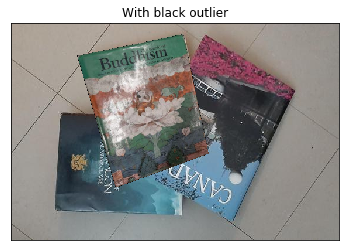

In [36]:
# # Create a rotated, scaled duplicate
# # rotation marix around the center pixel, -30 degrees,scale of 1
# # Actually get the pivot, so it not necessary is 1/2
# M_rotated = cv2.getRotationMatrix2D((width/2,height/2),15,0.65)
# # Apply the transformation matrix
# # Why i need the size of the image: if I transform it (rotate it) the object is actually out of the image
# img_crop_copy = cv2.warpAffine(img_crop_copy,M_rotated,(width,height))

# Compute a homography to align the images using RANSAC method and apply the transformation on the reference image.
# Arrange matching keypoints in two separate lists
GoodMatches = []
for i, m in enumerate(matches):
    if m.distance < 200:
        GoodMatches.append((m.queryIdx, m.trainIdx))
mp_occlusion = np.float32([keypoints_occlusion[i].pt for (i, __) in GoodMatches])
mp_crop = np.float32([keypoints_crop[i].pt for (__, i) in GoodMatches])

H, __ = cv2.findHomography(mp_crop, mp_occlusion, cv2.RANSAC, 1)

wimg = cv2.warpPerspective(img_crop_copy, H, (img_occlusion_copy.shape[1]+img_crop_copy.shape[1]
                                                   ,img_crop_copy.shape[0]))

B = wimg
for i in range(B.shape[0]):
    for j in range(B.shape[1]):
            if np.all(B[i, j] != 0):
                img_occlusion[i,j] = wimg[i,j]



                
plt.imshow(img_occlusion)
plt.title("With black outlier"), plt.xticks([]), plt.yticks([])
plt.show()

# plt.imshow(B)
# plt.title("B"), plt.xticks([]), plt.yticks([])
# plt.show()
# img_occlusion = cv2.medianBlur(img_occlusion, 19)
                
# plt.imshow(img_occlusion)
# plt.title("With black outlier"), plt.xticks([]), plt.yticks([])
# plt.show()



In [37]:
# img_occlusion_copy = img_occlusion.copy()
# plt.imshow(img_occlusion_copy)
# plt.title("img_occlusion_copy"), plt.xticks([]), plt.yticks([])
# plt.show()  

# for i in range(img_occlusion_copy.shape[0]):
#     for j in range(img_occlusion_copy.shape[1]):
#             if np.all(img_occlusion_copy[i, j] == 0):
#                 img_occlusion_copy[i, j] = 0
#             else:
#                 img_occlusion_copy[i, j] = 255
# plt.imshow(img_occlusion_copy)
# plt.title("img_occlusion_copy"), plt.xticks([]), plt.yticks([])
# plt.show()
# for i in range(img_occlusion_copy.shape[0]):
#     for j in range(img_occlusion_copy.shape[1]):
#         for k in range(img_occlusion_copy.shape[2]):
#             if np.all(img_occlusion_copy[i, j, k] == 0):
#                 img_occlusion[i, j, k] = img[i, j, k]
# plt.imshow(img_occlusion)
# plt.title("img_occlusion"), plt.xticks([]), plt.yticks([])
# plt.show()              
                

In [38]:
# # width and height of image
# col, row = wimg.shape[0:2]

# """ ALPHA BLENDING """
# def Ramp(i_width, c_width, c_index, start, end):
#     """
#     Create alpha blending function
#     :param i_width: img width
#     :param r_width: ramp width
#     :param r_index: center ramp index
#     :param start: starting ramp value
#     :param end: ending ramp value
#     :return:
#     """
#     a = np.zeros((i_width))
#     step = (end - start) / (c_width-1)
#     idx = round(c_index - (c_width / 2))  # left side starting index of alpha ramp
#     for i in range(c_width):
#         a[idx] = start + step*i
#         idx += 1
#     a[idx:] = 1
#     return a

# # alpha blending ramp
# ramp_size = 100  # alpha blending ramp size
# B = np.zeros_like(wimg)
# alpha = Ramp(B.shape[1], ramp_size, 250, 0.65, 1).reshape(1, -1, 1)
# # print(alpha)
# # Now blend
# I_blend = alpha * wimg + (1-alpha)*B
# I_blend = np.uint8(I_blend)  # convert back to uint8
# # I_blend = cv2.cvtColor(I_blend, cv2.COLOR_BGR2RGB)
# # I_blend = np.zeros_like(I_blend)
# for i in range(I_blend.shape[0]):
#     for j in range(I_blend.shape[1]):
#         for k in range(I_blend.shape[2]):
#             if np.all(I_blend[i, j, k] != 0):
#                 img_occlusion[i,j,k] = I_blend[i,j,k]

# plt.imshow(img_occlusion)
# plt.title("Panoramic image"), plt.xticks([]), plt.yticks([])
# plt.show()
# plt.figure(figsize=(20,20))
# plt.imshow(img_crop_copy)
# plt.title("Matched Keypoints"), plt.xticks([]), plt.yticks([])
# plt.subplot(312)
# plt.imshow(img_occlusion)
# plt.title("New"), plt.xticks([]), plt.yticks([])
# plt.subplot(313)
# plt.imshow(wimg)
# plt.title("Panoramic image"), plt.xticks([]), plt.yticks([])
# plt.show()
# plt.imshow(I_blend)
# plt.title("Alpha Blending"), plt.xticks([]), plt.yticks([])
# plt.show()
# # # apply gaussian filter
